# Download de imagens de Satélite utilizando GEE api em Python a partir de shapefile

Criação: Sabrina Paes Leme (paeslemesa@gmai.com) <br>
Data de criação: 27/03/2024 <br>

É necessário ter conta no __Google Earth Engine__ (GEE) para dar prosseguimento!

In [8]:
#Caso não tenha a biblioteca instalada, descomente a linha abaixo
#!pip install ee geemap pycrs

## 1. Importando bibliotecas

In [1]:
# 1. Bibliotecas relacionadas ao GEE
import ee # Biblioiteca Earth Engine
import geemap # Biblioteca Geemap

# 2. Bibliotecas auxiliares
import geopandas as gpd # Biblioteca de manipulação de dados geoespaciais
import numpy as np # Biblioteca de manipulação de arrays
from shapely.geometry import Polygon # Biblioteca de manipulação de geometrias
import rasterio # Biblioteca de manipulação de imagens raster
import os # Biblioteca de manipulação de arquivos
import  glob # Biblioteca de manipulação de arquivos
import requests # Biblioteca de requisições HTTP
import zipfile # Biblioteca de manipulação de arquivos zip


Para podermos logar no __GEE__, devemos utilizar o código abaixo, que vai nos redirecionar para uma página e devemos seguir o processo até aparecer algo similar a imagem abaixo para copiarmos o código e colar aqui no Notebook. <br>
O __GEE Python API__ apenas roda em Notebooks!

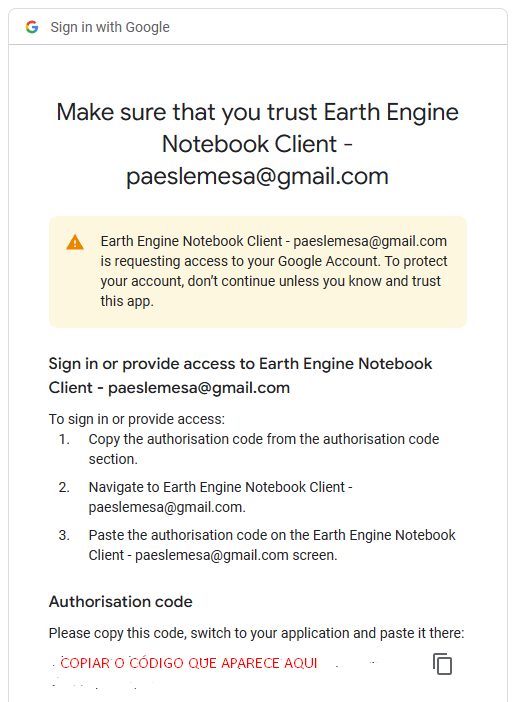

In [2]:
# 3. Autenticação no GEE
ee.Authenticate()

# 4. Inicialização do GEE
ee.Initialize()

## 2. Determinando as entradas

Aqui nós vamos inserir o caminho do nosso shapefile de entrada e as datas que queremos trabalhar.

Observação: o shapefile de entrada deve estar no sistema __EPSG:4326__

In [3]:
cam_shp = "D:/Pesquisa/Artigo_Mestrado/00_Dados/AOI.shp" # Caminho do shapefile inteiro (polígono)

data_ini = "2023-01-01" # Data de início da série temporal em formato "YYYY-MM-DD"
data_fim = "2024-03-30" # Data de fim da série temporal em formato "YYYY-MM-DD"

perce_nuvens = 20 # Porcentagem de nuvens máxima aceitável


cam_saida = r"D:/Pesquisa/Artigo_Mestrado/01_Imagens/Sentinel2" # Caminho de saída das imagens
bandas = ["B2", "B3", "B4","B8", "B8A"] # Bandas do Sentinel 2

### 2.1. Lendo o shapefile

In [4]:
geom = geemap.shp_to_ee(cam_shp) # Função para converter shapefile em geometria do GEE

# Abrindo a geometria em forma ee. Nesse caso, podemos perceber
geom

## 3. Acessando ao catálogo de imagens do GEE

Neste caso, usaremos imagens Bottom-Of-Atmosphere (BOA) do Sentinel-2. <br>
A referência para acessar este catálogo está em: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#colab-python


In [5]:
# Adicionando função de máscara de nuvens (código do GEE)
# Esta função serve como exemplo de como aplicar função do GEE no Python API
def mask_s2_clouds(image):
    """ Mascara nuvens do Sentinel-2 usando banda QA.
    Args:
        image (ee.Image): Uma imagens do Sentinel-2.
    Returns:
        ee.Image: Uma imagem com máscara aplicada do Sentinel-2.
    """
    qa = image.select('QA60')

    # Bits 10 e 11 são nuvens e cirrus, respectivamente.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Ambos os bits devem ser definidos como zero, indicando condições claras.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(data_ini, data_fim)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', perce_nuvens))
    .filterBounds(geom)
    .map(mask_s2_clouds)
)

#dataset

### 3.1. Visualizando os dados

Neste caso, estamos calculando a mediana entre todas as imagens de entrada.<br>
Devemos transformar o catálogo em uma única imagem, para isto, outras opções são:
* Selecionar a primeira imagem com <code>dataset.first()</code>
* Calcular o mosaico das imagens com <code>dataset.mosaic()</code>
* Calcular a média das imagens com <code>dataset.mean()</code>

In [8]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.centerObject(geom, 13)
m.add_layer(dataset.median().clip(geom), visualization, 'RGB')
m.addLayer(geom, {}, 'Área de Interesse')
m

Map(center=[-3.6521489312356517, -52.5171171175822], controls=(WidgetControl(options=['position', 'transparent…

## 4. Baixando uma única imagem

In [9]:
imagem = dataset.median().clip(geom) # Imagem mediana da coleção de imagens clipada de acordo com nossa area de interessa

imagem = imagem.select(bandas) # Selecionando as bandas de interesse

# O que saiu disso aí?
#imagem

Determinando as coordenadas para baixar as imagens. É mais prático e rápido fazer usando o Geopandas

In [10]:
gdf = gpd.read_file(cam_shp) # Lendo o shapefile
coords = gdf.geometry.bounds.values[0] # Pegando as coordenadas do shapefile

bbox = [[coords[0], coords[1]],
        [coords[0], coords[3]],
        [coords[2], coords[3]],
        [coords[2], coords[1]],
        [coords[0], coords[1]]]   

Neste momento, estamos determinando as configurações de download que usaremos

In [11]:
configuracao_tarefa = {"image" : imagem, # Imagem que será exportada
                       "description" : "Sentinel2", # uma descrição qualquer
                       "region" : bbox, # Bounding Box da área de interesse
                       "scale" : 10, # resolucao em metros
                       "crs": 'EPSG:4326', # CRS de saída, pode alterar aqui para o CRS desejado
                       "fileNamePrefix": imagem.id().getInfo(), # Prefixo do nome do arquivo
                       "fileFormat" : "GeoTIFF", # Formato do raster de saída
                       }


Vamos baixar a imagem separadas por bandas num arquivo ZIP a partir de uma URL e depois vamos unir todas as bandas numa imagem só.


In [12]:
download_url = imagem.getDownloadURL(configuracao_tarefa)  # Pegando a URL de download
nome_zip = os.path.join(cam_saida, f"Sentinel2_{data_ini}_{data_fim}.zip") # Nome do arquivo zipado de saída

resposta = requests.get(download_url) # Fazendo a requisição da URL

with open(nome_zip, 'wb') as f: # Escrevendo o arquivo zipado
    f.write(resposta.content)

# Agora você deve ter um arquivo zipado com a imagem que você solicitou no caminho de saída que você definiu
    
# Este código abaixo descompacta o arquivo zipado
with zipfile.ZipFile(nome_zip, 'r') as zip_file: # Abrindo o arquivo zipado
    zip_file.extractall(cam_saida)  # Extraindo o arquivo zipado


Juntando as bandas numa única imagem

In [13]:
# Em primeiro momento, devemos definir o nome do arquivo de saída
arquivo_saida = os.path.join(cam_saida, f"Sentinel2_{data_ini}_{data_fim}.tif")

# Agora vamos encontrar os tifs exportados do ZIP
lista_imgs = glob.glob(os.path.join(cam_saida, "*.tif")) # Lista de arquivos tif no caminho de saída


# Agora vamos criar um loop para abrir os arquivos tif e concatenar as bandas
for i, arquivo in enumerate(lista_imgs): # Loop para abrir os arquivos TIF
    if i == 0:
        # Para a primeira imagem, vamos abrir o arquivo e pegar as informações de perfil
        with rasterio.open(arquivo) as src:
            perfil = src.profile # pegando informações de coordenadas e metadados da imagem
            img = src.read(1) # lendo a primeira banda
            img = img[np.newaxis,:,:] # adicionando uma dimensão ao array para concatenar as outras bandas
    else:
        # Para as demais imagens, vamos abrir o arquivo e concatenar as bandas
        with rasterio.open(arquivo) as src:
            img = np.concatenate((img, src.read(1)[np.newaxis,:,:]), axis=0) # concatenando as bandas


# Como pegamos os metadados apenas de uma banda, precisamos atualizar o perfil com as informações de todas as bandas
perfil.update({"count": img.shape[0]})

# Agora vamos escrever o arquivo de saída
with rasterio.open(arquivo_saida, 'w', **perfil) as dst: # Escrevendo o arquivo de saída
    dst.write(img) # Escrevendo as bandas


Se quisermos deletar automaticamente os TIFs das bandas para economizar espaço no computador, basta rodar a célula abaixo

In [14]:
for arquivo in lista_imgs: # Deletando os arquivos tif
    if arquivo != arquivo_saida:
        os.remove(arquivo)